In [1]:
import pandas as pd

db1 = pd.read_csv('validated_en.tsv', sep='\t')
db2 = pd.read_csv('clip_durations_en.tsv', sep='\t')

db1.head()


,client_id,path,sentence,up_votes,down_votes,age,gender,accents,variant,locale,segment
0,00cb430b113e0ac0ec056de203bfcefbd45ea814b48460...,common_voice_en_39584989.mp3,These locomotives are serviced at Washwood Heath.,2,0,NaN,NaN,NaN,NaN,en,NaN
1,02cc5a0c68b0ac69c83a24da884f3e7069f63b0078cddb...,common_voice_en_39576542.mp3,"Here, she turned her inspirations towards writ...",3,0,NaN,NaN,"England English,Esturine, from the region arou...",NaN,en,NaN
2,02e97f2f112f01eee1db675e7eb23850294dc865524581...,common_voice_en_39582342.mp3,There is also a garnet mine in West Redding.,2,0,NaN,NaN,NaN,NaN,en,NaN
3,02fa98c5a9a3e74e0014dec1e4825a9e29f7b918de2278...,common_voice_en_38497561.mp3,"They hastily drive to the plane, and flee from...",2,0,NaN,NaN,"canadian - toronto english,Canadian English",NaN,en,NaN
4,04347480ab0b18a8f9c3285107d106945cb2b14d430cdc...,common_voice_en_39263187.mp3,They found one such edge in Fairbairn's system.,2,1,NaN,NaN,NaN,NaN,en,NaN


In [2]:
db2.head()

,clip,duration[ms]
0,common_voice_en_38739592.mp3,7056
1,common_voice_en_38964148.mp3,3492
2,common_voice_en_38694636.mp3,3636
3,common_voice_en_38627562.mp3,5256
4,common_voice_en_39017255.mp3,4608


In [4]:
import pandas as pd

# Define validated.tsv files for all languages
validated_files = {
    'English': ['validated_en.tsv', 'validated_en1.tsv'],  # Two files for English
    'French': ['validated_fr.tsv'],  # Single file for French
    'German': ['validated_de.tsv']   # Single file for German
}

# Combine all validated files for each language
combined_validated = pd.DataFrame()

for language, file_list in validated_files.items():
    # Load and combine files for the language
    validated_data = pd.concat([pd.read_csv(file, sep='\t') for file in file_list], ignore_index=True)
    
    # Keep only necessary columns
    validated_data = validated_data[['path', 'sentence']]
    validated_data['language'] = language  # Add language column
    
    # Append to the combined DataFrame
    combined_validated = pd.concat([combined_validated, validated_data], ignore_index=True)

# Save combined validated data (optional)
combined_validated.to_csv('combined_validated.tsv', index=False)
print(f"Total rows in combined_validated: {len(combined_validated)}")

Total rows in combined_validated: 25763


In [6]:
# Define clip_durations.tsv files for all languages
duration_files = {
    'English': ['clip_durations_en.tsv', 'clip_durations_en1.tsv'],  # Two files for English
    'French': ['clip_durations_fr.tsv'],  # Single file for French
    'German': ['clip_durations_de.tsv']   # Single file for German
}

# Combine all duration files for each language
combined_durations = pd.DataFrame()

for language, file_list in duration_files.items():
    # Load and combine files for the language
    durations_data = pd.concat([pd.read_csv(file, sep='\t') for file in file_list], ignore_index=True)
    
    # Keep only necessary columns
    durations_data = durations_data[['clip', 'duration[ms]']]
    
    
    # Append to the combined DataFrame
    combined_durations = pd.concat([combined_durations, durations_data], ignore_index=True)

# Save combined durations data (optional)
combined_durations.to_csv('combined_durations.tsv', index=False)
print(f"Total rows in combined_durations: {len(combined_durations)}")

Total rows in combined_durations: 2408329


In [7]:
# Merge validated and durations data
final_data = pd.merge(combined_validated, combined_durations, left_on='path', right_on='clip', how='inner')

# Convert duration from milliseconds to seconds
final_data['duration_seconds'] = final_data['duration[ms]'] / 1000

# Save the merged dataset (optional)
final_data.to_csv('final_merged_data.tsv', index=False)
print(f"Total rows in final_data: {len(final_data)}")


Total rows in final_data: 25763


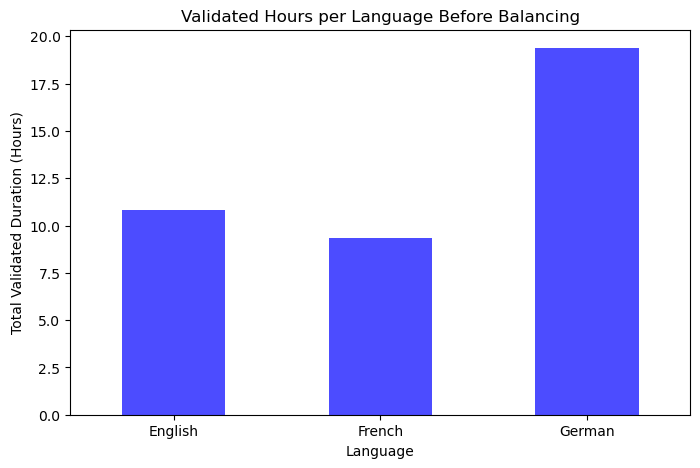

Validated hours per language before balancing:
language
English    10.81890
French      9.33775
German     19.37929
Name: duration_seconds, dtype: float64


In [8]:
import matplotlib.pyplot as plt

# Calculate total validated duration before balancing (in hours)
validated_hours_before = final_data.groupby('language')['duration_seconds'].sum() / 3600  # Convert seconds to hours

# Plot total validated hours before balancing
plt.figure(figsize=(8, 5))
validated_hours_before.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel('Language')
plt.ylabel('Total Validated Duration (Hours)')
plt.title('Validated Hours per Language Before Balancing')
plt.xticks(rotation=0)
plt.show()

# Print summary
print("Validated hours per language before balancing:")
print(validated_hours_before)

In [9]:
# Set desired total duration per language (9 hours = 32400 seconds)
desired_duration = 9 * 3600  # 9 hours in seconds

balanced_data = pd.DataFrame()

# Balance dataset for each language
for language in final_data['language'].unique():
    lang_data = final_data[final_data['language'] == language]
    
    # Calculate cumulative duration
    lang_data = lang_data.sort_values(by='duration_seconds', ascending=False)  # Optional: Use longer clips first
    lang_data['cumulative_duration'] = lang_data['duration_seconds'].cumsum()
    
    # Filter to match the desired duration
    lang_data = lang_data[lang_data['cumulative_duration'] <= desired_duration]
    
    # Append to balanced dataset
    balanced_data = pd.concat([balanced_data, lang_data], ignore_index=True)

# Save balanced dataset
balanced_data.to_csv('balanced_data.tsv', index=False)
print(f"Balanced dataset saved successfully with {len(balanced_data)} rows!")

Balanced dataset saved successfully with 15386 rows!


In [10]:
# Check total duration for each language
total_duration_per_language = balanced_data.groupby('language')['duration_seconds'].sum()
print(total_duration_per_language / 3600)  # Convert to hours

# Check number of clips per language
clip_count_per_language = balanced_data['language'].value_counts()
print(clip_count_per_language)


language
English    8.99959
French     8.99912
German     8.99989
Name: duration_seconds, dtype: float64
language
French     5958
English    4870
German     4558
Name: count, dtype: int64


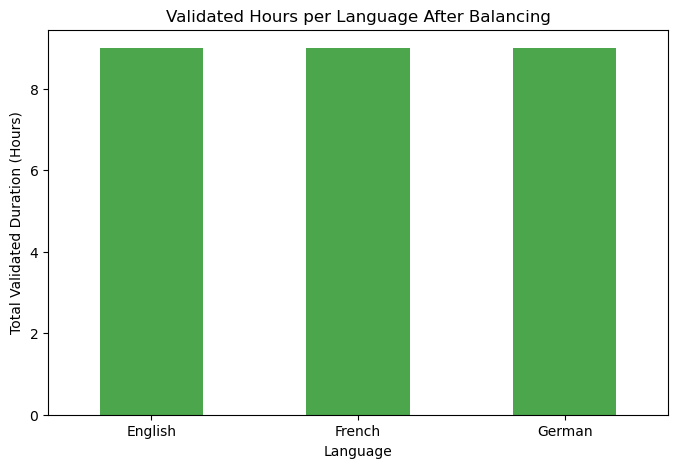

Validated hours per language after balancing:
language
English    8.99959
French     8.99912
German     8.99989
Name: duration_seconds, dtype: float64


In [11]:
# Calculate total validated duration after balancing (in hours)
validated_hours_after = balanced_data.groupby('language')['duration_seconds'].sum() / 3600  # Convert seconds to hours

# Plot total validated hours after balancing
plt.figure(figsize=(8, 5))
validated_hours_after.plot(kind='bar', color='green', alpha=0.7)
plt.xlabel('Language')
plt.ylabel('Total Validated Duration (Hours)')
plt.title('Validated Hours per Language After Balancing')
plt.xticks(rotation=0)
plt.show()

# Print summary
print("Validated hours per language after balancing:")
print(validated_hours_after)

In [12]:
# Add the 'clips/' folder to the path column
balanced_data['path'] = "clips/" + balanced_data['path']

# Save the updated dataset (optional)
balanced_data.to_csv('balanced_data.tsv', index=False)
print("Updated dataset paths saved successfully!")

Updated dataset paths saved successfully!


In [13]:
balanced_data.head()

,path,sentence,language,clip,duration[ms],duration_seconds,cumulative_duration
0,clips/common_voice_en_38352658.mp3,It features a real-time encoding and decoding ...,English,common_voice_en_38352658.mp3,10656,10.656,10.656
1,clips/common_voice_en_38083406.mp3,"He attended schools in Washington, New Hampshi...",English,common_voice_en_38083406.mp3,10548,10.548,21.204
2,clips/common_voice_en_38690188.mp3,"These groups emphasized direct action, informa...",English,common_voice_en_38690188.mp3,10548,10.548,31.752
3,clips/common_voice_en_38690815.mp3,"His son, the third Viscount, was Member of Par...",English,common_voice_en_38690815.mp3,10548,10.548,42.300
4,clips/common_voice_en_38718914.mp3,York says immanent theology distinguishes mode...,English,common_voice_en_38718914.mp3,10476,10.476,52.776
